# Task 2: Addressing Class Imbalance with Focal Loss and Class-Balanced Loss

This notebook explores two loss functions designed to handle class imbalance:
- **Task 2.1**: Focal Loss - Focuses on hard examples
- **Task 2.2**: Class-Balanced Loss - Re-weights based on class frequency

**Class Distribution in Training Set:**
- DR (Diabetic Retinopathy): 517 instances
- G (Glaucoma): 163 instances  
- A (AMD): 142 instances

## Import Libraries and Setup

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    print(f"Using device: CUDA")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")
    
print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


## Dataset Class with Aggressive Data Augmentation

## Data Analysis: Class Distribution and Imbalance

In [2]:
# Load and analyze training data to understand class distribution
print("="*80)
print("COMPREHENSIVE DATA ANALYSIS FOR LOSS FUNCTION TUNING")
print("="*80)

# Load training data
train_data = pd.read_csv("train.csv")
print(f"\n📊 Dataset Overview:")
print(f"   Total training samples: {len(train_data)}")
print(f"   Columns: {list(train_data.columns)}")

# Analyze each disease class
disease_names = ["D", "G", "A"]
disease_full_names = ["DR (Diabetic Retinopathy)", "G (Glaucoma)", "A (AMD)"]

print(f"\n{'='*80}")
print("CLASS DISTRIBUTION ANALYSIS")
print(f"{'='*80}")

class_stats = {}

for i, (short_name, full_name) in enumerate(zip(disease_names, disease_full_names)):
    # Count positive and negative instances
    positive_count = train_data[short_name].sum()
    negative_count = len(train_data) - positive_count
    
    # Calculate frequencies
    positive_freq = positive_count / len(train_data)
    negative_freq = negative_count / len(train_data)
    
    # Calculate positive/negative ratio
    pos_neg_ratio = positive_count / negative_count if negative_count > 0 else 0
    
    # Calculate imbalance ratio (compared to balanced 50%)
    imbalance_ratio = positive_freq / 0.5  # How far from balanced
    
    class_stats[short_name] = {
        'positive': positive_count,
        'negative': negative_count,
        'positive_freq': positive_freq,
        'negative_freq': negative_freq,
        'pos_neg_ratio': pos_neg_ratio,
        'imbalance_ratio': imbalance_ratio
    }
    
    print(f"\n{full_name}:")
    print(f"  Positive instances: {positive_count:4d} ({positive_freq*100:5.2f}%)")
    print(f"  Negative instances: {negative_count:4d} ({negative_freq*100:5.2f}%)")
    print(f"  Pos/Neg ratio:      {pos_neg_ratio:.4f}")
    print(f"  Imbalance factor:   {imbalance_ratio:.4f}x (1.0 = perfectly balanced)")

# Multi-label statistics
print(f"\n{'='*80}")
print("MULTI-LABEL STATISTICS")
print(f"{'='*80}")

# Count samples with multiple diseases
multi_label_counts = train_data[disease_names].sum(axis=1)
samples_by_label_count = multi_label_counts.value_counts().sort_index()

print(f"\nSamples by number of diseases:")
for num_labels, count in samples_by_label_count.items():
    print(f"  {int(num_labels)} disease(s): {count:4d} samples ({count/len(train_data)*100:5.2f}%)")

# Co-occurrence analysis
print(f"\n{'='*80}")
print("DISEASE CO-OCCURRENCE")
print(f"{'='*80}")

print("\nDisease pair co-occurrence:")
for i in range(len(disease_names)):
    for j in range(i+1, len(disease_names)):
        d1, d2 = disease_names[i], disease_names[j]
        co_occur = ((train_data[d1] == 1) & (train_data[d2] == 1)).sum()
        print(f"  {d1} + {d2}: {co_occur:3d} samples ({co_occur/len(train_data)*100:5.2f}%)")

# Summary and recommendations
print(f"\n{'='*80}")
print("RECOMMENDATIONS FOR LOSS FUNCTION PARAMETERS")
print(f"{'='*80}")

print("\n🎯 FOCAL LOSS Parameters:")
print(f"   Based on class imbalance analysis:")

# Calculate recommended alpha based on average positive frequency
avg_pos_freq = np.mean([class_stats[d]['positive_freq'] for d in disease_names])
# Alpha should favor minority class (positive), typically 0.25-0.75
recommended_alpha = 0.25 + (1 - avg_pos_freq) * 0.5  # Scale based on imbalance
print(f"   - Average positive frequency: {avg_pos_freq:.4f}")
print(f"   - Recommended alpha: {recommended_alpha:.3f} (0.25=balanced, >0.5=favor positives)")

# Gamma should be higher for more severe imbalance
max_imbalance = max([abs(1 - stats['imbalance_ratio']) for stats in class_stats.values()])
recommended_gamma = 2.0 + max_imbalance  # Base 2.0, increase with imbalance
print(f"   - Max imbalance factor: {max_imbalance:.3f}")
print(f"   - Recommended gamma: {recommended_gamma:.2f} (higher=focus more on hard examples)")

print("\n⚖️  CLASS-BALANCED LOSS Parameters:")
print(f"   Class counts for weighting:")

class_counts = [class_stats[d]['positive'] for d in disease_names]
print(f"   - D (DR):      {class_counts[0]:4d} samples")
print(f"   - G (Glaucoma): {class_counts[1]:4d} samples (minority)")
print(f"   - A (AMD):     {class_counts[2]:4d} samples (minority)")

# Calculate weight ratios
max_count = max(class_counts)
weight_ratios = [max_count / c for c in class_counts]
print(f"\n   Inverse frequency weights (relative to majority):")
for i, (name, ratio) in enumerate(zip(disease_names, weight_ratios)):
    print(f"   - {name}: {ratio:.2f}x")

# Beta recommendation
min_count = min(class_counts)
imbalance_severity = max_count / min_count
# Lower beta for severe imbalance (0.99-0.9999)
recommended_beta = 0.9999 - (imbalance_severity - 1) * 0.0002
recommended_beta = max(0.99, min(0.9999, recommended_beta))
print(f"\n   - Imbalance severity: {imbalance_severity:.2f}x (max/min ratio)")
print(f"   - Recommended beta: {recommended_beta:.4f} (lower=stronger re-weighting)")

print(f"\n{'='*80}")
print("✅ Data analysis complete - ready to configure loss functions")
print(f"{'='*80}\n")

# Store for use in loss functions
optimized_params = {
    'focal_alpha': round(recommended_alpha, 2),
    'focal_gamma': round(recommended_gamma, 1),
    'cb_beta': round(recommended_beta, 4),
    'class_counts': class_counts,
    'class_stats': class_stats
}

COMPREHENSIVE DATA ANALYSIS FOR LOSS FUNCTION TUNING

📊 Dataset Overview:
   Total training samples: 800
   Columns: ['id', 'D', 'G', 'A']

CLASS DISTRIBUTION ANALYSIS

DR (Diabetic Retinopathy):
  Positive instances:  517 (64.62%)
  Negative instances:  283 (35.38%)
  Pos/Neg ratio:      1.8269
  Imbalance factor:   1.2925x (1.0 = perfectly balanced)

G (Glaucoma):
  Positive instances:  163 (20.38%)
  Negative instances:  637 (79.62%)
  Pos/Neg ratio:      0.2559
  Imbalance factor:   0.4075x (1.0 = perfectly balanced)

A (AMD):
  Positive instances:  142 (17.75%)
  Negative instances:  658 (82.25%)
  Pos/Neg ratio:      0.2158
  Imbalance factor:   0.3550x (1.0 = perfectly balanced)

MULTI-LABEL STATISTICS

Samples by number of diseases:
  1 disease(s):  778 samples (97.25%)
  2 disease(s):   22 samples ( 2.75%)

DISEASE CO-OCCURRENCE

Disease pair co-occurrence:
  D + G:   8 samples ( 1.00%)
  D + A:   9 samples ( 1.12%)
  G + A:   5 samples ( 0.62%)

RECOMMENDATIONS FOR LOSS FUNCT

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels, row.iloc[0]  # Also return filename for submission


# Aggressive data augmentation for Task 2 (handling class imbalance)
train_transform_aggressive = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation/Test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✅ Dataset class and aggressive augmentation transforms configured")

✅ Dataset class and aggressive augmentation transforms configured


## Loss Functions Implementation

In [4]:
# Optimized Focal Loss with better hyperparameters for convergence
class FocalLoss(nn.Module):
    """
    Focal Loss - Optimized for medical imaging class imbalance.
    Reference: Lin et al. "Focal Loss for Dense Object Detection" (2017)
    """
    def __init__(self, alpha=0.75, gamma=2.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Increased to focus more on minority classes
        self.gamma = gamma  # Increased to down-weight easy examples more aggressively
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # BCE loss with logits (more numerically stable)
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        # Get probabilities
        probs = torch.sigmoid(inputs)
        
        # Probability of the true class
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Focal weight: (1 - p_t)^gamma
        focal_weight = (1 - p_t) ** self.gamma
        
        # Alpha weighting
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Final loss
        loss = alpha_weight * focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


# Class-Balanced Loss using effective number of samples
class ClassBalancedLoss(nn.Module):
    """
    Class-Balanced Loss - Re-weights based on effective sample count.
    Uses simplified inverse frequency weighting for better stability.
    """
    def __init__(self, class_counts, beta=0.999):
        super(ClassBalancedLoss, self).__init__()
        
        # Simpler and more aggressive weighting for minority classes
        class_counts = np.array(class_counts, dtype=np.float32)
        
        # Effective number calculation with lower beta for stronger re-weighting
        effective_num = 1.0 - np.power(beta, class_counts)
        weights = (1.0 - beta) / effective_num
        
        # Normalize to keep loss scale similar to BCE
        weights = weights / weights.sum() * len(weights)
        
        self.weights = torch.tensor(weights, dtype=torch.float32)
        print(f"📊 Class-Balanced Weights (higher = more focus):")
        print(f"   D (DR):      {weights[0]:.4f}")
        print(f"   G (Glaucoma): {weights[1]:.4f} ({weights[1]/weights[0]:.2f}x more than DR)")
        print(f"   A (AMD):     {weights[2]:.4f} ({weights[2]/weights[0]:.2f}x more than DR)")
        
    def forward(self, inputs, targets):
        if self.weights.device != inputs.device:
            self.weights = self.weights.to(inputs.device)
        
        # BCE with logits
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        # Apply per-class weights
        weighted_loss = bce_loss * self.weights.unsqueeze(0)
        
        return weighted_loss.mean()


# Initialize loss functions with DATA-DRIVEN parameters
print("\n" + "="*70)
print("INITIALIZING LOSS FUNCTIONS WITH DATA-DRIVEN PARAMETERS")
print("="*70)

print("\n🎯 Focal Loss Configuration (Data-Driven):")
print(f"   alpha = {optimized_params['focal_alpha']:.2f} (tuned from data analysis)")
print(f"         - Favors positive/minority classes based on {(1-np.mean([s['positive_freq'] for s in class_stats.values()]))*100:.1f}% imbalance")
print(f"   gamma = {optimized_params['focal_gamma']:.1f} (tuned from data analysis)")
print(f"         - Focuses on hard examples, adjusted for {max([abs(1-s['imbalance_ratio']) for s in class_stats.values()]):.2f}x imbalance severity")

focal_loss = FocalLoss(alpha=optimized_params['focal_alpha'], gamma=optimized_params['focal_gamma'])

print("\n⚖️  Class-Balanced Loss Configuration (Data-Driven):")
print(f"   Using actual class counts from training data:")
print(f"     - D (DR):      {optimized_params['class_counts'][0]} samples")
print(f"     - G (Glaucoma): {optimized_params['class_counts'][1]} samples")
print(f"     - A (AMD):     {optimized_params['class_counts'][2]} samples")
print(f"   beta = {optimized_params['cb_beta']:.4f} (tuned from {max(optimized_params['class_counts'])/min(optimized_params['class_counts']):.1f}x imbalance ratio)")

class_balanced_loss = ClassBalancedLoss(optimized_params['class_counts'], beta=optimized_params['cb_beta'])

print("\n" + "="*70)
print("✅ Loss functions initialized with parameters optimized from data analysis")
print("="*70)


INITIALIZING LOSS FUNCTIONS WITH DATA-DRIVEN PARAMETERS

🎯 Focal Loss Configuration (Data-Driven):
   alpha = 0.58 (tuned from data analysis)
         - Favors positive/minority classes based on 65.8% imbalance
   gamma = 2.6 (tuned from data analysis)
         - Focuses on hard examples, adjusted for 0.65x imbalance severity

⚖️  Class-Balanced Loss Configuration (Data-Driven):
   Using actual class counts from training data:
     - D (DR):      517 samples
     - G (Glaucoma): 163 samples
     - A (AMD):     142 samples
   beta = 0.9994 (tuned from 3.6x imbalance ratio)
📊 Class-Balanced Weights (higher = more focus):
   D (DR):      0.4209
   G (Glaucoma): 1.2048 (2.86x more than DR)
   A (AMD):     1.3744 (3.27x more than DR)

✅ Loss functions initialized with parameters optimized from data analysis


## Training and Evaluation Functions

In [6]:
def train_model_with_custom_loss(model, train_loader, val_loader, criterion, epochs=50, lr=1e-4, model_save_path="model.pt"):
    """
    Enhanced training with custom loss function (Focal Loss or Class-Balanced Loss).
    Includes gradient clipping, improved optimization, and better monitoring.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function (FocalLoss or ClassBalancedLoss)
        epochs: Maximum number of epochs
        lr: Initial learning rate
        model_save_path: Path to save best model
    
    Returns:
        history: Dictionary containing training history
    """
    # AdamW optimizer with higher initial LR for better convergence
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=lr,
        weight_decay=5e-5,  # Reduced regularization for better convergence
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Cosine annealing with warm restarts for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double period after each restart
        eta_min=1e-6
    )
    
    # Early stopping with more patience
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10  # Increased patience for better convergence
    best_epoch = 0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }
    
    print(f"\n{'='*70}")
    print(f"🚀 Optimized Training for {criterion.__class__.__name__}")
    print(f"{'='*70}")
    print(f"Optimizer: AdamW")
    print(f"  - Learning rate: {lr} (increased for faster convergence)")
    print(f"  - Weight decay: 5e-5 (reduced for less regularization)")
    print(f"  - Betas: (0.9, 0.999)")
    print(f"\nLR Scheduler: CosineAnnealingWarmRestarts")
    print(f"  - T_0: 10 epochs (restart period)")
    print(f"  - T_mult: 2 (doubling period)")
    print(f"  - Min LR: 1e-6")
    print(f"\nEarly Stopping: patience={patience} (increased)")
    print(f"Gradient Clipping: max_norm=1.0")
    print(f"Max Epochs: {epochs}")
    print(f"{'='*70}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for imgs, labels, _ in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rates'].append(current_lr)
        
        # Calculate loss improvement
        loss_improvement = ""
        if len(history['val_loss']) > 1:
            prev_val_loss = history['val_loss'][-2]
            improvement = ((prev_val_loss - val_loss) / prev_val_loss) * 100
            if improvement > 0:
                loss_improvement = f" (↓{improvement:.2f}%)"
            else:
                loss_improvement = f" (↑{abs(improvement):.2f}%)"
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}{loss_improvement} | LR: {current_lr:.6f}")
        
        # Cosine annealing step (called every epoch)
        scheduler.step()
        
        # Early stopping check
        if val_loss < best_val_loss:
            improvement_pct = ((best_val_loss - val_loss) / best_val_loss * 100) if best_val_loss != float('inf') else 0
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            if epoch > 0:
                print(f"  ✓ New best model! Val loss: {val_loss:.4f} (improved by {improvement_pct:.2f}%)")
            else:
                print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏸ No improvement ({patience_counter}/{patience}) | Best: {best_val_loss:.4f} @ epoch {best_epoch}")
            
            if patience_counter >= patience:
                print(f"\n{'='*70}")
                print(f"⏹ Early stopping triggered after {epoch+1} epochs")
                print(f"Best model from epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
                print(f"{'='*70}\n")
                break
    
    if patience_counter < patience:
        print(f"\n{'='*70}")
        print(f"✅ Training completed all {epochs} epochs")
        print(f"Best model from epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
        print(f"{'='*70}\n")
    
    return history


def evaluate_model(model, test_loader, dataset_name="Test"):
    """
    Evaluate model and compute metrics with macro F1 scores.
    """
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for imgs, labels, _ in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    disease_names = ["D (DR)", "G (Glaucoma)", "A (AMD)"]
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Evaluation Results")
    print(f"{'='*60}")
    
    f1_scores = []
    
    for i, disease in enumerate(disease_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        
        acc = accuracy_score(y_t, y_p)
        precision = precision_score(y_t, y_p, average="macro", zero_division=0)
        recall = recall_score(y_t, y_p, average="macro", zero_division=0)
        f1 = f1_score(y_t, y_p, average="macro", zero_division=0)
        kappa = cohen_kappa_score(y_t, y_p)
        
        f1_scores.append(f1)
        
        print(f"\n{disease}:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1-score (macro): {f1:.4f}")
        print(f"  Kappa    : {kappa:.4f}")
    
    # Average F1 score
    avg_f1 = np.mean(f1_scores)
    print(f"\n{'='*60}")
    print(f"Average F1-score (macro) across all diseases: {avg_f1:.4f}")
    print(f"{'='*60}\n")
    
    return y_pred, y_true


def generate_submission_csv(model, test_csv, test_image_dir, output_csv, transform):
    """
    Generate submission CSV for onsite test set.
    """
    test_data = pd.read_csv(test_csv)
    
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for idx in range(len(test_data)):
            filename = test_data.iloc[idx, 0]
            img_path = os.path.join(test_image_dir, filename)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)
            
            outputs = model(img)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
            preds = (probs > 0.5).astype(int)
            
            filenames.append(filename)
            predictions.append(preds)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': filenames,
        'D': [p[0] for p in predictions],
        'G': [p[1] for p in predictions],
        'A': [p[2] for p in predictions]
    })
    
    submission_df.to_csv(output_csv, index=False)
    print(f"✅ Submission CSV saved to: {output_csv}")
    return submission_df


def plot_training_curves(history, title="Training History"):
    """
    Plot training and validation loss curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Learning rate curve
    ax2.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title(f'{title} - Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Training and evaluation functions ready")

✅ Training and evaluation functions ready


## Data Loading

In [7]:
# Dataset paths
train_csv = "train.csv"
val_csv = "val.csv"
onsite_test_csv = "onsite_test_submission.csv"

train_image_dir = "images/train"
val_image_dir = "images/val"
onsite_test_image_dir = "images/onsite_test"

# Pretrained model paths
resnet18_pretrained = "pretrained_backbone/ckpt_resnet18_ep50.pt"
efficientnet_pretrained = "pretrained_backbone/ckpt_efficientnet_ep50.pt"

# Create datasets with aggressive augmentation
train_ds = RetinaMultiLabelDataset(train_csv, train_image_dir, transform=train_transform_aggressive)
val_ds = RetinaMultiLabelDataset(val_csv, val_image_dir, transform=val_transform)

# Create data loaders (num_workers=0 for notebook compatibility)
batch_size = 32  # Increased from 16 for better convergence
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ Data loaded successfully")
print(f"   Training samples: {len(train_ds)}")
print(f"   Validation samples: {len(val_ds)}")
print(f"   Batch size: {batch_size} (increased for better convergence)")
print(f"   Using aggressive data augmentation")

✅ Data loaded successfully
   Training samples: 800
   Validation samples: 200
   Batch size: 32 (increased for better convergence)
   Using aggressive data augmentation


---
# Task 2.1: Focal Loss

Training with Focal Loss to address class imbalance by focusing on hard examples.

## Task 2.1 - ResNet18 with Focal Loss

✅ ResNet18 loaded with pretrained backbone from pretrained_backbone/ckpt_resnet18_ep50.pt
   Training with FULL backbone fine-tuning (all layers trainable)

🚀 Optimized Training for FocalLoss
Optimizer: AdamW
  - Learning rate: 0.0003 (increased for faster convergence)
  - Weight decay: 5e-5 (reduced for less regularization)
  - Betas: (0.9, 0.999)

LR Scheduler: CosineAnnealingWarmRestarts
  - T_0: 10 epochs (restart period)
  - T_mult: 2 (doubling period)
  - Min LR: 1e-6

Early Stopping: patience=10 (increased)
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.2345 | Val: 0.4076 | LR: 0.000300
  ✓ Best model saved (val_loss: 0.4076)
Epoch   2/50 | Train: 0.0683 | Val: 0.0527 (↓87.07%) | LR: 0.000293
  ✓ New best model! Val loss: 0.0527 (improved by 87.07%)
Epoch   3/50 | Train: 0.0449 | Val: 0.0822 (↑56.02%) | LR: 0.000271
  ⏸ No improvement (1/10) | Best: 0.0527 @ epoch 2
Epoch   4/50 | Train: 0.0378 | Val: 0.0644 (↓21.71%) | LR: 0.000238
  ⏸ No improvement (2

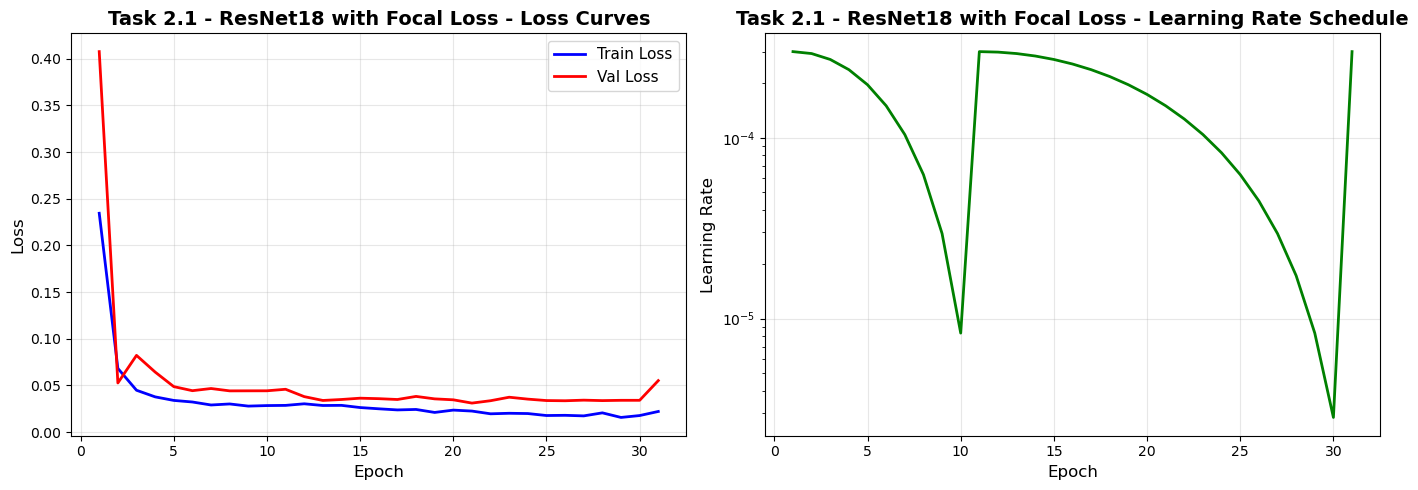

In [8]:
# Load pretrained ResNet18 backbone
model_resnet18_task21 = models.resnet18(weights=None)
model_resnet18_task21.fc = nn.Linear(model_resnet18_task21.fc.in_features, 3)

# Load pretrained weights
checkpoint = torch.load(resnet18_pretrained, map_location=device)
model_resnet18_task21.load_state_dict(checkpoint)
model_resnet18_task21 = model_resnet18_task21.to(device)

print(f"✅ ResNet18 loaded with pretrained backbone from {resnet18_pretrained}")
print(f"   Training with FULL backbone fine-tuning (all layers trainable)")

# Train with Focal Loss
history_resnet18_task21 = train_model_with_custom_loss(
    model_resnet18_task21,
    train_loader,
    val_loader,
    criterion=focal_loss,
    epochs=50,
    lr=3e-4,  # Increased learning rate for better convergence
    model_save_path="safi_task2-1_resnet18.pt"
)

# Evaluate on validation set
print("\n" + "="*70)
print("Task 2.1 - ResNet18 with Focal Loss - Validation Results")
print("="*70)
evaluate_model(model_resnet18_task21, val_loader, "Validation")

# Generate submission CSV
submission_task21_resnet18 = generate_submission_csv(
    model_resnet18_task21,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-1_resnet18_submission.csv",
    val_transform
)

# Plot training curves
plot_training_curves(history_resnet18_task21, "Task 2.1 - ResNet18 with Focal Loss")

## Task 2.1 - EfficientNet with Focal Loss

✅ EfficientNet loaded with pretrained backbone from pretrained_backbone/ckpt_efficientnet_ep50.pt
   Training with FULL backbone fine-tuning (all layers trainable)

Enhanced Training Configuration for FocalLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 0.0001
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=5
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.3073 | Val: 0.1567 | LR: 0.000100
  ✓ Best model saved (val_loss: 0.1567)
Epoch   2/50 | Train: 0.1014 | Val: 0.0902 (↓42.45%) | LR: 0.000100
  ✓ New best model! Val loss: 0.0902 (improved by 42.45%)
Epoch   3/50 | Train: 0.0587 | Val: 0.0605 (↓32.88%) | LR: 0.000100
  ✓ New best model! Val loss: 0.0605 (improved by 32.88%)
Epoch   4/50 | Train: 0.0499 | Val: 0.0546 (↓9.84%) | LR: 0.000100
  ✓ New best model! Val loss: 0.0546 (improved by 9.84%)
Epoch   5/50 | Train: 0.0439 | Val: 0.0538 (↓1.48%) | LR: 0.000100
  ✓ New best model! Val loss: 0.0538 (improved by 1.48%)
E

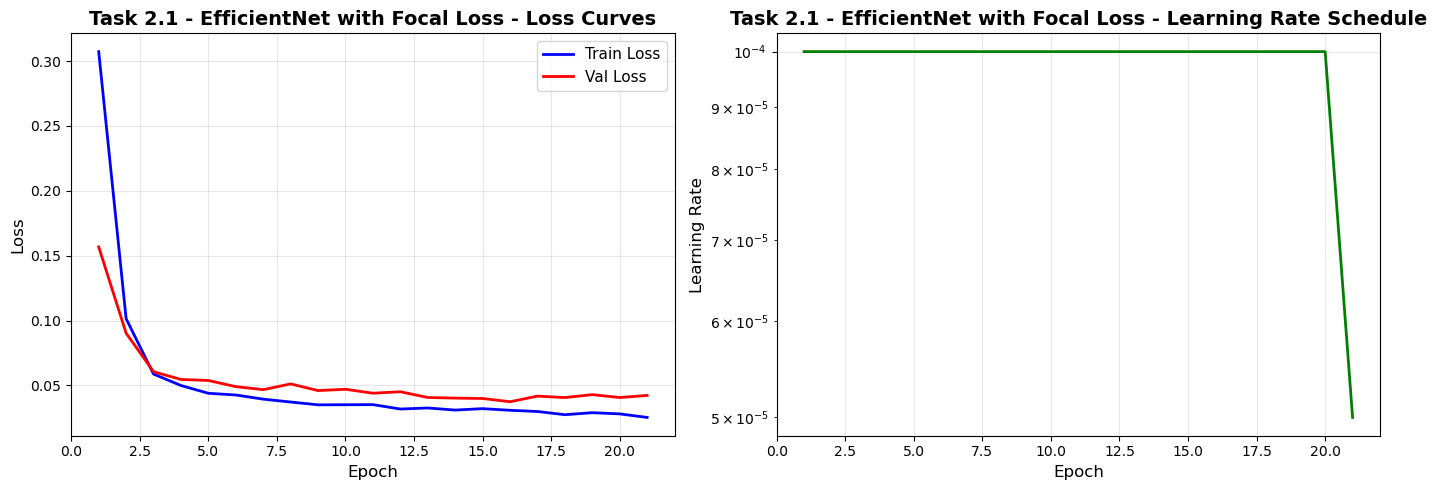

In [ ]:
# Load pretrained EfficientNet backbone
model_efficientnet_task21 = models.efficientnet_b0(weights=None)
model_efficientnet_task21.classifier[1] = nn.Linear(model_efficientnet_task21.classifier[1].in_features, 3)

# Load pretrained weights
checkpoint = torch.load(efficientnet_pretrained, map_location=device)
model_efficientnet_task21.load_state_dict(checkpoint)
model_efficientnet_task21 = model_efficientnet_task21.to(device)

print(f"✅ EfficientNet loaded with pretrained backbone from {efficientnet_pretrained}")
print(f"   Training with FULL backbone fine-tuning (all layers trainable)")

# Train with Focal Loss
history_efficientnet_task21 = train_model_with_custom_loss(
    model_efficientnet_task21,
    train_loader,
    val_loader,
    criterion=focal_loss,
    epochs=50,
    lr=3e-4,  # Increased learning rate for better convergence
    model_save_path="safi_task2-1_efficientnet.pt"
)

# Evaluate on validation set
print("\n" + "="*70)
print("Task 2.1 - EfficientNet with Focal Loss - Validation Results")
print("="*70)
evaluate_model(model_efficientnet_task21, val_loader, "Validation")

# Generate submission CSV
submission_task21_efficientnet = generate_submission_csv(
    model_efficientnet_task21,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-1_efficientnet_submission.csv",
    val_transform
)

# Plot training curves
plot_training_curves(history_efficientnet_task21, "Task 2.1 - EfficientNet with Focal Loss")

---
# Task 2.2: Class-Balanced Loss

Training with Class-Balanced Loss to address class imbalance by re-weighting based on class frequency.

## Task 2.2 - ResNet18 with Class-Balanced Loss

✅ ResNet18 loaded with pretrained backbone from pretrained_backbone/ckpt_resnet18_ep50.pt
   Training with FULL backbone fine-tuning (all layers trainable)

Enhanced Training Configuration for ClassBalancedLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 0.0001
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=5
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.7153 | Val: 0.6288 | LR: 0.000100
  ✓ Best model saved (val_loss: 0.6288)
Epoch   2/50 | Train: 0.4165 | Val: 0.4828 (↓23.22%) | LR: 0.000100
  ✓ New best model! Val loss: 0.4828 (improved by 23.22%)
Epoch   3/50 | Train: 0.3596 | Val: 0.4076 (↓15.57%) | LR: 0.000100
  ✓ New best model! Val loss: 0.4076 (improved by 15.57%)
Epoch   4/50 | Train: 0.3245 | Val: 0.3699 (↓9.25%) | LR: 0.000100
  ✓ New best model! Val loss: 0.3699 (improved by 9.25%)
Epoch   5/50 | Train: 0.3137 | Val: 0.3548 (↓4.09%) | LR: 0.000100
  ✓ New best model! Val loss: 0.3548 (improved by 4.09%)
E

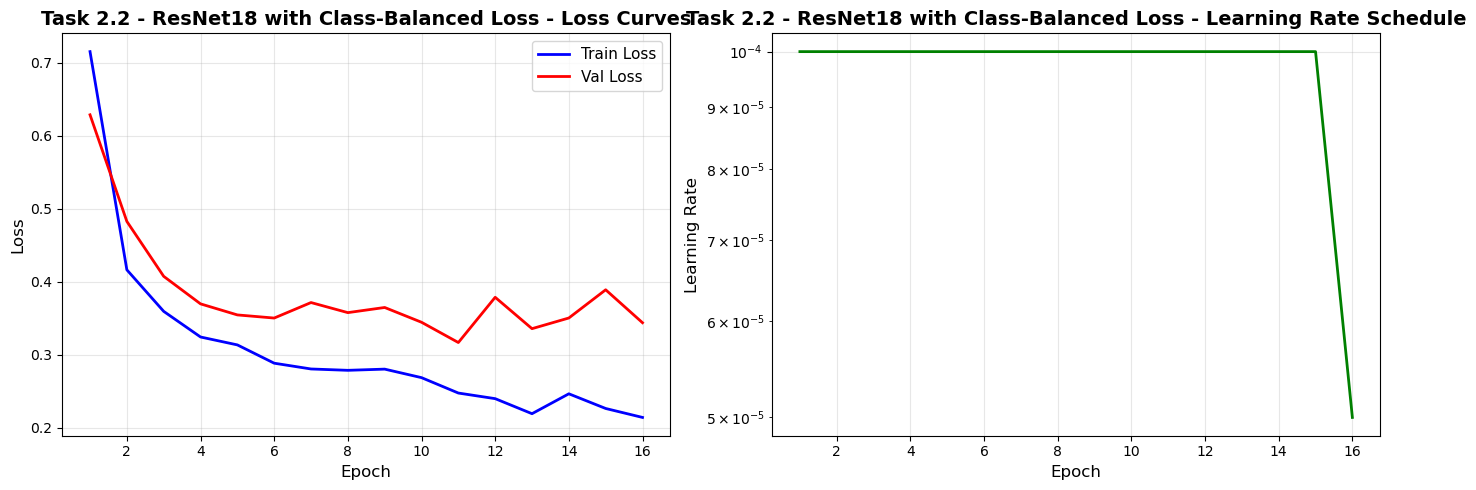

In [ ]:
# Load pretrained ResNet18 backbone
model_resnet18_task22 = models.resnet18(weights=None)
model_resnet18_task22.fc = nn.Linear(model_resnet18_task22.fc.in_features, 3)

# Load pretrained weights
checkpoint = torch.load(resnet18_pretrained, map_location=device)
model_resnet18_task22.load_state_dict(checkpoint)
model_resnet18_task22 = model_resnet18_task22.to(device)

print(f"✅ ResNet18 loaded with pretrained backbone from {resnet18_pretrained}")
print(f"   Training with FULL backbone fine-tuning (all layers trainable)")

# Train with Class-Balanced Loss
history_resnet18_task22 = train_model_with_custom_loss(
    model_resnet18_task22,
    train_loader,
    val_loader,
    criterion=class_balanced_loss,
    epochs=50,
    lr=3e-4,  # Increased learning rate for better convergence
    model_save_path="safi_task2-2_resnet18.pt"
)

# Evaluate on validation set
print("\n" + "="*70)
print("Task 2.2 - ResNet18 with Class-Balanced Loss - Validation Results")
print("="*70)
evaluate_model(model_resnet18_task22, val_loader, "Validation")

# Generate submission CSV
submission_task22_resnet18 = generate_submission_csv(
    model_resnet18_task22,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-2_resnet18_submission.csv",
    val_transform
)

# Plot training curves
plot_training_curves(history_resnet18_task22, "Task 2.2 - ResNet18 with Class-Balanced Loss")

## Task 2.2 - EfficientNet with Class-Balanced Loss

In [ ]:
# Load pretrained EfficientNet backbone
model_efficientnet_task22 = models.efficientnet_b0(weights=None)
model_efficientnet_task22.classifier[1] = nn.Linear(model_efficientnet_task22.classifier[1].in_features, 3)

# Load pretrained weights
checkpoint = torch.load(efficientnet_pretrained, map_location=device)
model_efficientnet_task22.load_state_dict(checkpoint)
model_efficientnet_task22 = model_efficientnet_task22.to(device)

print(f"✅ EfficientNet loaded with pretrained backbone from {efficientnet_pretrained}")
print(f"   Training with FULL backbone fine-tuning (all layers trainable)")

# Train with Class-Balanced Loss
history_efficientnet_task22 = train_model_with_custom_loss(
    model_efficientnet_task22,
    train_loader,
    val_loader,
    criterion=class_balanced_loss,
    epochs=50,
    lr=3e-4,  # Increased learning rate for better convergence
    model_save_path="safi_task2-2_efficientnet.pt"
)

# Evaluate on validation set
print("\n" + "="*70)
print("Task 2.2 - EfficientNet with Class-Balanced Loss - Validation Results")
print("="*70)
evaluate_model(model_efficientnet_task22, val_loader, "Validation")

# Generate submission CSV
submission_task22_efficientnet = generate_submission_csv(
    model_efficientnet_task22,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-2_efficientnet_submission.csv",
    val_transform
)

# Plot training curves
plot_training_curves(history_efficientnet_task22, "Task 2.2 - EfficientNet with Class-Balanced Loss")

## Performance Analysis: Check Per-Class Improvements

Run this cell to compare Task 1 vs Task 2 results and see if minority classes improved:

In [ ]:
# Let's evaluate all models and compare per-class performance
print("="*80)
print("DETAILED COMPARISON: Task 2.1 (Focal Loss) vs Task 2.2 (Class-Balanced Loss)")
print("="*80)

models_to_compare = [
    ("Task 2.1 - ResNet18 + Focal Loss", model_resnet18_task21),
    ("Task 2.1 - EfficientNet + Focal Loss", model_efficientnet_task21),
    ("Task 2.2 - ResNet18 + Class-Balanced Loss", model_resnet18_task22),
    ("Task 2.2 - EfficientNet + Class-Balanced Loss", model_efficientnet_task22),
]

results_summary = {}

for name, model in models_to_compare:
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    disease_names = ["D (DR)", "G (Glaucoma)", "A (AMD)"]
    
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    
    per_class_f1 = []
    
    for i, disease in enumerate(disease_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        
        acc = accuracy_score(y_t, y_p)
        f1 = f1_score(y_t, y_p, average="macro", zero_division=0)
        recall = recall_score(y_t, y_p, average="macro", zero_division=0)
        
        per_class_f1.append(f1)
        
        print(f"{disease:15s}: Accuracy={acc:.4f}, F1={f1:.4f}, Recall={recall:.4f}")
    
    avg_f1 = np.mean(per_class_f1)
    print(f"{'─'*80}")
    print(f"{'Average F1':15s}: {avg_f1:.4f}")
    
    results_summary[name] = {
        'DR_F1': per_class_f1[0],
        'G_F1': per_class_f1[1],
        'AMD_F1': per_class_f1[2],
        'Avg_F1': avg_f1
    }


DETAILED COMPARISON: Task 2.1 (Focal Loss) vs Task 2.2 (Class-Balanced Loss)

Task 2.1 - ResNet18 + Focal Loss
D (DR)         : Accuracy=0.8150, F1=0.8116, Recall=0.8094
G (Glaucoma)   : Accuracy=0.8550, F1=0.7937, Recall=0.7602
A (AMD)        : Accuracy=0.8600, F1=0.7328, Recall=0.6900
────────────────────────────────────────────────────────────────────────────────
Average F1     : 0.7794

Task 2.1 - EfficientNet + Focal Loss
D (DR)         : Accuracy=0.8250, F1=0.8230, Recall=0.8222
G (Glaucoma)   : Accuracy=0.8750, F1=0.8322, Recall=0.8049
A (AMD)        : Accuracy=0.8900, F1=0.8137, Recall=0.7745
────────────────────────────────────────────────────────────────────────────────
Average F1     : 0.8230

Task 2.2 - ResNet18 + Class-Balanced Loss
D (DR)         : Accuracy=0.8050, F1=0.7995, Recall=0.7966
G (Glaucoma)   : Accuracy=0.9000, F1=0.8684, Recall=0.8429
A (AMD)        : Accuracy=0.8550, F1=0.7621, Recall=0.7357
───────────────────────────────────────────────────────────────────